In [5]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [6]:
import math, time, sys, os
import numpy as np
from numpy import sqrt,cos,ma
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as nc
from   matplotlib.backends.backend_pdf import PdfPages
from   matplotlib.patches import Polygon
from   netCDF4 import Dataset as open_ncfile
from matplotlib.pyplot import figure
import scipy
from scipy.ndimage import convolve1d
from scipy.signal import savgol_coeffs, savgol_filter
from scipy.signal._savitzky_golay import _polyder
from scipy.interpolate import griddata
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import colors
import matplotlib.patches as patches
import datetime
from datetime import date, timedelta
import os
import subprocess
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics import root_mean_squared_error, r2_score
from math import sqrt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [7]:
############################################ Input #######################################
data_era5="/work/cmcc/vr25423/Project/AdriaClimPlus/data/data_ERA5/processed"
data_medcordex_ssp245="/work/cmcc/vr25423/Project/AdriaClimPlus/data/data_MEDCORDEX/processed_SSP245_ERA5"
data_medcordex_ssp585="/work/cmcc/vr25423/Project/AdriaClimPlus/data/data_MEDCORDEX/processed_SSP585_ERA5"

# Land sea mask #
lsm_f = open_ncfile("/work/cmcc/vr25423/Project/AdriaClimPlus/data/data_ERA5/downloaded/land_sea_mask.nc","r")
##########################################################################################

In [8]:
def root_mean_squared_error_calc(true, pred):
    squared_diff = (true - pred) ** 2
    mean_squared_error = np.nanmean(squared_diff)
    return np.sqrt(mean_squared_error)

def r2_score_calc(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    ss_res = np.sum((y_true_filtered - y_pred_filtered) ** 2)
    ss_tot = np.sum((y_true_filtered - np.mean(y_true_filtered)) ** 2)
    
    r2 = 1 - (ss_res / ss_tot)
    return r2

def is_leap_year(year):
    return (year % 4 == 0)

In [11]:
yr_v = ['1985', '1986', '1987', '1988', '1989',
        '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
        '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
        '2020', '2021', '2022', '2023']


t2_era5 = []
t2_medcordex_ssp245 = []
t2_medcordex_ssp585 = []
for year in yr_v:
    t2_era5_winter = open_ncfile(str(data_era5)+"/ERA5_"+str(year)+"_t2m_winter.nc","r")
    t2_era5_spring = open_ncfile(str(data_era5)+"/ERA5_"+str(year)+"_t2m_spring.nc","r")
    t2_era5_summer = open_ncfile(str(data_era5)+"/ERA5_"+str(year)+"_t2m_summer.nc","r")
    t2_era5_autumn = open_ncfile(str(data_era5)+"/ERA5_"+str(year)+"_t2m_autumn.nc","r")
    lat_e = t2_era5_winter.variables["latitude"][:]
    lon_e = t2_era5_winter.variables["longitude"][:]
    lat_e_ind = np.where((lat_e>=29.78) & (lat_e<=48.89))
    lon_e_ind = np.where((lon_e>=5.03) & (lon_e<=22.92))
    t2_medcordex_ssp245_winter = open_ncfile(str(data_medcordex_ssp245)+"/MEDCORDEX_"+str(year)+"_t2m_remap_winter.nc","r")
    t2_medcordex_ssp245_spring = open_ncfile(str(data_medcordex_ssp245)+"/MEDCORDEX_"+str(year)+"_t2m_remap_spring.nc","r")
    t2_medcordex_ssp245_summer = open_ncfile(str(data_medcordex_ssp245)+"/MEDCORDEX_"+str(year)+"_t2m_remap_summer.nc","r")
    t2_medcordex_ssp245_autumn = open_ncfile(str(data_medcordex_ssp245)+"/MEDCORDEX_"+str(year)+"_t2m_remap_autumn.nc","r")
    t2_medcordex_ssp585_winter = open_ncfile(str(data_medcordex_ssp585)+"/MEDCORDEX_"+str(year)+"_t2m_remap_winter.nc","r")
    t2_medcordex_ssp585_spring = open_ncfile(str(data_medcordex_ssp585)+"/MEDCORDEX_"+str(year)+"_t2m_remap_spring.nc","r")
    t2_medcordex_ssp585_summer = open_ncfile(str(data_medcordex_ssp585)+"/MEDCORDEX_"+str(year)+"_t2m_remap_summer.nc","r")
    t2_medcordex_ssp585_autumn = open_ncfile(str(data_medcordex_ssp585)+"/MEDCORDEX_"+str(year)+"_t2m_remap_autumn.nc","r")
    lat_m = t2_medcordex_ssp245_winter.variables["latitude"][:]
    lon_m = t2_medcordex_ssp245_winter.variables["longitude"][:]
    lat_m_ind = np.where((lat_m>=29.78) & (lat_m<=48.89))
    lon_m_ind = np.where((lon_m>=5.03) & (lon_m<=22.92))

    lsm=lsm_f.variables["lsm"][0,lat_m_ind[0],lon_m_ind[0]] # 0 --> sea, above zero --> land.
    
    if is_leap_year(int(year)):
        t2_era5_winter1 = (t2_era5_winter.variables["t2m"][0,lat_e_ind[0],lon_e_ind[0]]-273.15)*364
        t2_era5_spring1 = (t2_era5_spring.variables["t2m"][0,lat_e_ind[0],lon_e_ind[0]]-273.15)*364
        t2_era5_summer1 = (t2_era5_summer.variables["t2m"][0,lat_e_ind[0],lon_e_ind[0]]-273.15)*368
        t2_era5_autumn1 = (t2_era5_autumn.variables["t2m"][0,lat_e_ind[0],lon_e_ind[0]]-273.15)*368
        t2_era5_winter1 = np.where(lsm > 0.1, np.nan, t2_era5_winter1)
        t2_era5_spring1 = np.where(lsm > 0.1, np.nan, t2_era5_spring1)
        t2_era5_summer1 = np.where(lsm > 0.1, np.nan, t2_era5_summer1)
        t2_era5_autumn1 = np.where(lsm > 0.1, np.nan, t2_era5_autumn1)
        t2_era5.append(np.nanmean((t2_era5_winter1+t2_era5_spring1+t2_era5_summer1+t2_era5_autumn1)/(364+364+368+368)))

        t2_medcordex_ssp245_winter1=(t2_medcordex_ssp245_winter.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*364
        t2_medcordex_ssp245_spring1=(t2_medcordex_ssp245_spring.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*364
        t2_medcordex_ssp245_summer1=(t2_medcordex_ssp245_summer.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*368
        t2_medcordex_ssp245_autumn1=(t2_medcordex_ssp245_autumn.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*368


        t2_medcordex_ssp245_winter2 = np.where(np.isnan(t2_era5_winter1), np.nan, t2_medcordex_ssp245_winter1)
        t2_medcordex_ssp245_spring2 = np.where(np.isnan(t2_era5_spring1), np.nan, t2_medcordex_ssp245_spring1)
        t2_medcordex_ssp245_summer2 = np.where(np.isnan(t2_era5_summer1), np.nan, t2_medcordex_ssp245_summer1)
        t2_medcordex_ssp245_autumn2 = np.where(np.isnan(t2_era5_autumn1), np.nan, t2_medcordex_ssp245_autumn1)
        t2_medcordex_ssp245.append(np.nanmean((t2_medcordex_ssp245_winter2+t2_medcordex_ssp245_spring2+t2_medcordex_ssp245_summer2+t2_medcordex_ssp245_autumn2)/(364+364+368+368)))

        t2_medcordex_ssp585_winter1=(t2_medcordex_ssp585_winter.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*364
        t2_medcordex_ssp585_spring1=(t2_medcordex_ssp585_spring.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*364
        t2_medcordex_ssp585_summer1=(t2_medcordex_ssp585_summer.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*368
        t2_medcordex_ssp585_autumn1=(t2_medcordex_ssp585_autumn.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*368

        t2_medcordex_ssp585_winter2 = np.where(np.isnan(t2_era5_winter1), np.nan, t2_medcordex_ssp585_winter1)
        t2_medcordex_ssp585_spring2 = np.where(np.isnan(t2_era5_spring1), np.nan, t2_medcordex_ssp585_spring1)
        t2_medcordex_ssp585_summer2 = np.where(np.isnan(t2_era5_summer1), np.nan, t2_medcordex_ssp585_summer1)
        t2_medcordex_ssp585_autumn2 = np.where(np.isnan(t2_era5_autumn1), np.nan, t2_medcordex_ssp585_autumn1)
        t2_medcordex_ssp585.append(np.nanmean((t2_medcordex_ssp585_winter2+t2_medcordex_ssp585_spring2+t2_medcordex_ssp585_summer2+t2_medcordex_ssp585_autumn2)/(364+364+368+368)))

    else:
        t2_era5_winter1 = (t2_era5_winter.variables["t2m"][0,lat_e_ind[0],lon_e_ind[0]]-273.15)*360
        t2_era5_spring1 = (t2_era5_spring.variables["t2m"][0,lat_e_ind[0],lon_e_ind[0]]-273.15)*364
        t2_era5_summer1 = (t2_era5_summer.variables["t2m"][0,lat_e_ind[0],lon_e_ind[0]]-273.15)*368
        t2_era5_autumn1 = (t2_era5_autumn.variables["t2m"][0,lat_e_ind[0],lon_e_ind[0]]-273.15)*368
        t2_era5_winter1 = np.where(lsm > 0.1, np.nan, t2_era5_winter1)
        t2_era5_spring1 = np.where(lsm > 0.1, np.nan, t2_era5_spring1)
        t2_era5_summer1 = np.where(lsm > 0.1, np.nan, t2_era5_summer1)
        t2_era5_autumn1 = np.where(lsm > 0.1, np.nan, t2_era5_autumn1)
        t2_era5.append(np.nanmean((t2_era5_winter1+t2_era5_spring1+t2_era5_summer1+t2_era5_autumn1)/(360+364+368+368)))

        t2_medcordex_ssp245_winter1=(t2_medcordex_ssp245_winter.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*360
        t2_medcordex_ssp245_spring1=(t2_medcordex_ssp245_spring.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*364
        t2_medcordex_ssp245_summer1=(t2_medcordex_ssp245_summer.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*368
        t2_medcordex_ssp245_autumn1=(t2_medcordex_ssp245_autumn.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*368

        t2_medcordex_ssp245_winter2 = np.where(np.isnan(t2_era5_winter1), np.nan, t2_medcordex_ssp245_winter1)
        t2_medcordex_ssp245_spring2 = np.where(np.isnan(t2_era5_spring1), np.nan, t2_medcordex_ssp245_spring1)
        t2_medcordex_ssp245_summer2 = np.where(np.isnan(t2_era5_summer1), np.nan, t2_medcordex_ssp245_summer1)
        t2_medcordex_ssp245_autumn2 = np.where(np.isnan(t2_era5_autumn1), np.nan, t2_medcordex_ssp245_autumn1)
        t2_medcordex_ssp245.append(np.nanmean((t2_medcordex_ssp245_winter2+t2_medcordex_ssp245_spring2+t2_medcordex_ssp245_summer2+t2_medcordex_ssp245_autumn2)/(360+364+368+368)))

        t2_medcordex_ssp585_winter1=(t2_medcordex_ssp585_winter.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*360
        t2_medcordex_ssp585_spring1=(t2_medcordex_ssp585_spring.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*364
        t2_medcordex_ssp585_summer1=(t2_medcordex_ssp585_summer.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*368
        t2_medcordex_ssp585_autumn1=(t2_medcordex_ssp585_autumn.variables["T2"][0,lat_m_ind[0],lon_m_ind[0]]-273.15)*368

        t2_medcordex_ssp585_winter2 = np.where(np.isnan(t2_era5_winter1), np.nan, t2_medcordex_ssp585_winter1)
        t2_medcordex_ssp585_spring2 = np.where(np.isnan(t2_era5_spring1), np.nan, t2_medcordex_ssp585_spring1)
        t2_medcordex_ssp585_summer2 = np.where(np.isnan(t2_era5_summer1), np.nan, t2_medcordex_ssp585_summer1)
        t2_medcordex_ssp585_autumn2 = np.where(np.isnan(t2_era5_autumn1), np.nan, t2_medcordex_ssp585_autumn1)
        t2_medcordex_ssp585.append(np.nanmean((t2_medcordex_ssp585_winter2+t2_medcordex_ssp585_spring2+t2_medcordex_ssp585_summer2+t2_medcordex_ssp585_autumn2)/(360+364+368+368)))



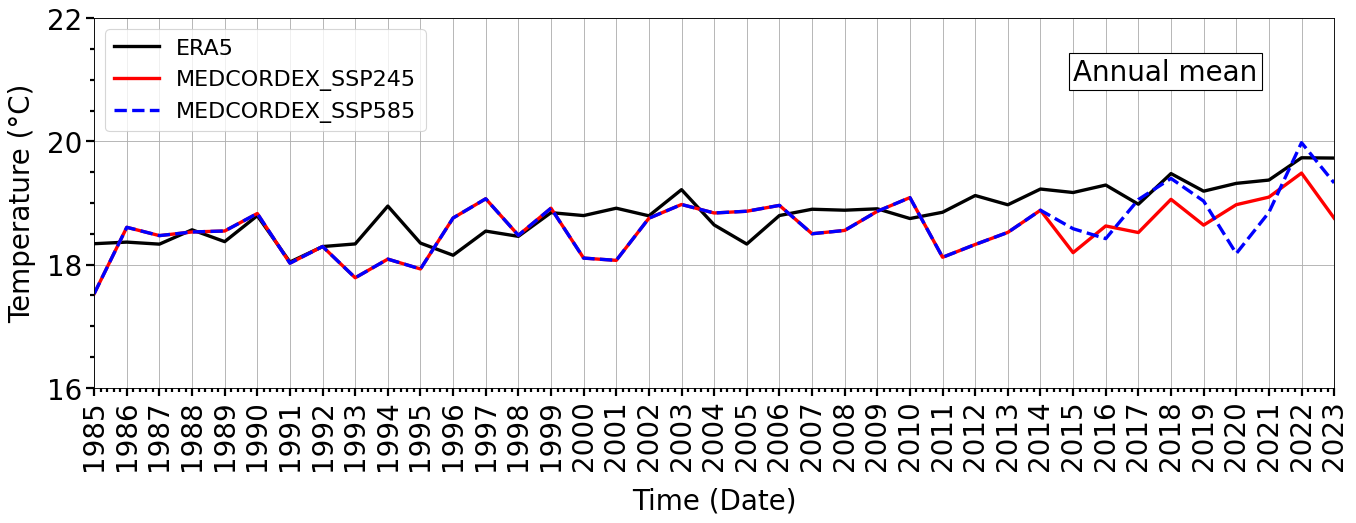

<Figure size 640x480 with 0 Axes>

In [15]:
################# Plot ###############
fig = plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace=0.6, wspace=0.1)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)

ax = fig.add_subplot(111)

ax.set_xlabel('Time (Date)',fontsize=25,labelpad=15)
ax.set_ylabel('Temperature (°C)', fontsize=25,labelpad=10)
ax.tick_params(axis='y', colors='black', which='both', width=2)
ax.yaxis.label.set_color('black')
ax.set_xticks(np.arange(0,39))
ax.set_xlim(0,38)
ax.set_xticklabels([str(year) for year in range(1985, 2024)], rotation=90)
ax.grid(visible=True, which='major', linestyle='-')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)



ax.plot(np.arange(len(t2_era5)), t2_era5, linestyle='-', color='black', linewidth=3.0)
ax.plot(np.arange(len(t2_medcordex_ssp245)), t2_medcordex_ssp245, linestyle='-', color='red', linewidth=3.0)
ax.plot(np.arange(len(t2_medcordex_ssp585)), t2_medcordex_ssp585, linestyle='--', color='blue', linewidth=3.0)


plt.legend(labels=['ERA5','MEDCORDEX_SSP245','MEDCORDEX_SSP585'],loc='upper left', fontsize=20)


#ax.set_ylim(0,14)
#ax.set_yticks(np.arange(0, 14, 2))
#ax.text(34, 12, "Winter", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

#ax.set_ylim(6,26)
#ax.set_yticks(np.arange(6, 28, 4))
#ax.text(34, 24, "Spring", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

#ax.set_ylim(10,35)
#ax.set_yticks(np.arange(10, 40, 5))
#ax.text(34, 33, "Summer", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

#ax.set_ylim(5,25)
#ax.set_yticks(np.arange(5, 30, 5))
#ax.text(34, 23, "Autumn", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

ax.set_ylim(16,22)
ax.set_yticks(np.arange(16, 24, 2))
ax.text(30, 21, "Annual mean", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()
plt.clf()

In [ ]:
### Extras ###

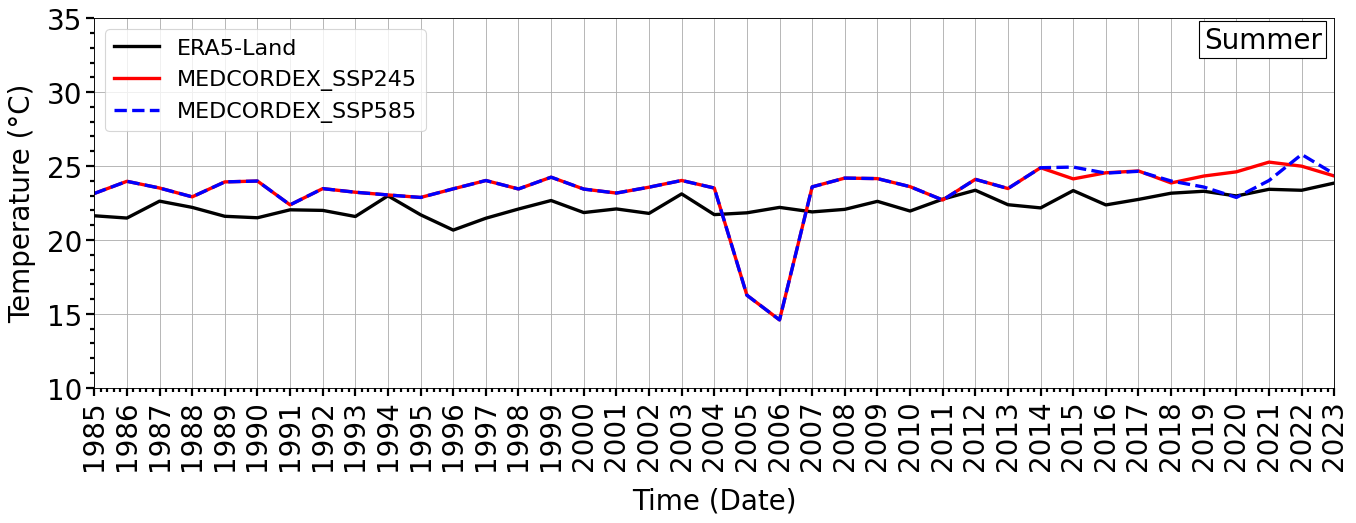

<Figure size 640x480 with 0 Axes>

In [35]:
################# Plot ###############
fig = plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace=0.6, wspace=0.1)
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)

ax = fig.add_subplot(111)

ax.set_xlabel('Time (Date)',fontsize=25,labelpad=15)
ax.set_ylabel('Temperature (°C)', fontsize=25,labelpad=10)
ax.tick_params(axis='y', colors='black', which='both', width=2)
ax.yaxis.label.set_color('black')
ax.set_xticks(np.arange(0,39))
ax.set_xlim(0,38)
ax.set_xticklabels([str(year) for year in range(1985, 2024)], rotation=90)
ax.grid(visible=True, which='major', linestyle='-')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)


#ax.plot(np.arange(len(t2_era5land_winter)), t2_era5land_winter, linestyle='-', color='black', linewidth=3.0)
#ax.plot(np.arange(len(t2_medcordex_ssp245_remap_winter_m)), t2_medcordex_ssp245_remap_winter_m, linestyle='-', color='red', linewidth=3.0)
#ax.plot(np.arange(len(t2_medcordex_ssp585_remap_winter_m)), t2_medcordex_ssp585_remap_winter_m, linestyle='--', color='blue', linewidth=3.0)

#ax.plot(np.arange(len(t2_era5land_spring)), t2_era5land_spring, linestyle='-', color='black', linewidth=3.0)
#ax.plot(np.arange(len(t2_medcordex_ssp245_remap_spring_m)), t2_medcordex_ssp245_remap_spring_m, linestyle='-', color='red', linewidth=3.0)
#ax.plot(np.arange(len(t2_medcordex_ssp585_remap_spring_m)), t2_medcordex_ssp585_remap_spring_m, linestyle='--', color='blue', linewidth=3.0)

ax.plot(np.arange(len(t2_era5land_summer)), t2_era5land_summer, linestyle='-', color='black', linewidth=3.0)
ax.plot(np.arange(len(t2_medcordex_ssp245_remap_summer_m)), t2_medcordex_ssp245_remap_summer_m, linestyle='-', color='red', linewidth=3.0)
ax.plot(np.arange(len(t2_medcordex_ssp585_remap_summer_m)), t2_medcordex_ssp585_remap_summer_m, linestyle='--', color='blue', linewidth=3.0)

#ax.plot(np.arange(len(t2_era5land_autumn)), t2_era5land_autumn, linestyle='-', color='black', linewidth=3.0)
#ax.plot(np.arange(len(t2_medcordex_ssp245_remap_autumn_m)), t2_medcordex_ssp245_remap_autumn_m, linestyle='-', color='red', linewidth=3.0)
#ax.plot(np.arange(len(t2_medcordex_ssp585_remap_autumn_m)), t2_medcordex_ssp585_remap_autumn_m, linestyle='--', color='blue', linewidth=3.0)
 

plt.legend(labels=['ERA5-Land','MEDCORDEX_SSP245','MEDCORDEX_SSP585'],loc='upper left', fontsize=20)


#ax.set_ylim(0,14)
#ax.set_yticks(np.arange(0, 14, 2))
#ax.text(34, 12, "Winter", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

#ax.set_ylim(6,26)
#ax.set_yticks(np.arange(6, 28, 4))
#ax.text(34, 24, "Spring", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

ax.set_ylim(10,35)
ax.set_yticks(np.arange(10, 40, 5))
ax.text(34, 33, "Summer", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

#ax.set_ylim(5,25)
#ax.set_yticks(np.arange(5, 30, 5))
#ax.text(34, 23, "Autumn", fontsize=25, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()
plt.clf()